# Project Report

In [1]:
# Run to load packages
install.packages("GGally")
install.packages("cowplot")

library(tidyverse)
library(repr)
library(dplyr)
library(tidymodels)
library(GGally)
library(cowplot)

also installing the dependencies ‘labelled’, ‘broom.helpers’, ‘ggplot2’, ‘ggstats’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.4     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ──────────────────

# Introduction:

Tennis is a popular sport among men and women all over the world. Therefore, the analysis of factors affecting performance and success is of great interest. Since tennis players' earnings can vary widely and "Prize Money” could reflect a player's earnings in tennis tournaments, understanding the determinants of prize money can provide insights into the financial success of professional tennis players. One main factor is ranking points. In professional tennis, players compete in various tournaments, accumulate ranking points, and move up or down in the rankings based on their performance. This system is used to determine tournament entries and player recognition. In our model, our research question is "How can we use ranking points to predict the prize money a tennis player receives?" To answer the question, we will be using the data `player_stats(1).csv` from Ultimate Tennis Statistics. This data set contains the statistics of the top 500 tennis players in the world.



****Working on more*****

Cited Source: https://olympics.com/en/news/tennis-rankings-atp-wta-men-women-doubles-singles-system-grand-slam-olympics

# Data Description:

We use data from Ultimate Tennis Statistics, which is based on the open-source tennis data repository by Jeff Sackmann with some corrections and additions for incorrect or missing data. This database provides users with a variety of tennis statistics for men's tennis during the Open period, such as historical results, in-match statistics, records or all-time greats comparisons. The extensive nature of the dataset makes it a valuable resource for conducting in-depth analyses and deriving insights into various facets of men's tennis during the specified Open period.

The original dataset contains 500 rows and 38 columns with 500 tennis players and 37 factors of interest. We have wrangled and cleaned the dataset so that we can focus only on the variables we want to explore. We have also removed all the "NA" values. The wrangled dataset contains 407 rows and 9 columns. 

Our dependent variable is a player's earnings in tennis tournaments which is represented by `prize_money` in our model (Unit: US dollar). Since prize money is a visual reflection of tennis players' income in the game, we set prize money as the independent variable. We predict the prize money income of professional tennis players in the subsequent data analysis to understand their economic success.

Our main independent variable are `best_rank` and `current_rank`; `best_rank` represents a player's the highest rank they have achieved. This variable can impact a player's reputation, endorsements, and invitations to play in future prestige tournaments. `current_rank` represents a tennis player's current rank. By analyzing the current ranks of players, it allows us to analyze how their ranking point may affect their progress; having a higher current rank will allow tennis players an opportunity to enter more honored tournaments, which will impact the amount of prize money they will earn. 

Our control variables are `age`, `dominant_dummy` (their playing hand), and `backhand_dummy` (the use of backhand plays). 
`age` is important since younger players may have more energy and stamina, potentially providing them with a competitive advantage. On the other hand, older players may have the experience and strategic depth, but their physical condition may decline. Dominant hand and the choice of backhand style can impact a player's style and game strategy, which might be reflected in their prize earnings. We transformed the qualitative variables to its respective dummy variables, 1 is for right handed while 0 is for left handed. All of these variables provide different dimensions of a player's career and can help create a more accurate model.

We have conducted a summary statistics table. For the "Variable" column, it lists the names or labels of the variables or features in our dataset. 
For the "Mean" column, it displays the average value of each variable. The mean is a measure of central tendency, representing the central or typical value in our dataset.
For the "Max" column, it shows the maximum value observed for each variable. This value represents the highest point or measurement in the dataset for a particular variable. It helps identify the upper limit or extreme values within the dataset.
For the "Min" column, it shows the minimum value observed for each variable. This value represents the lowest point or measurement in the dataset for a particular variable. It helps identify the lowest limit or extreme values within the dataset.


`age` - Player's age

`backhand_dummy` - Player's backhand style	(where 1 means "One-handed" and 0 means "Two-handed")

`best_rank` - Player's highest rank

`current_rank` - Player's current standing

`dominant_dummy` - Player's dominant hand (1 means "Right-handed" and 0 means "Left-handed)

`prize_money` - Player's prize money

Cited Source: https://www.ultimatetennisstatistics.com/about

In [2]:
# run to load data set
player_data <- read_csv("https://raw.githubusercontent.com/dcai01/dsci100_project/main/project_proposal/data/player_stats%20(1).csv")
num_rows <- nrow(player_data)
num_rows
num_cols <- ncol(player_data)
num_cols

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


[1] 500

[1] 38

In [3]:
head(player_data)
#The original dataset contains 500 rows and 38 columns with 500 tennis players and 37 factors of interest.

...1,Age,Country,Plays,Wikipedia,Current Rank,Best Rank,Name,Backhand,Prize Money,⋯,Facebook,Twitter,Nicknames,Grand Slams,Davis Cups,Web Site,Team Cups,Olympics,Weeks at No. 1,Tour Finals
<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,26 (25-04-1993),Brazil,Right-handed,Wikipedia,378 (97),363 (04-11-2019),Oscar Jose Gutierrez,NA,NA,⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
1,18 (22-12-2001),United Kingdom,Left-handed,Wikipedia,326 (119),316 (14-10-2019),Jack Draper,Two-handed,"$59,040",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
2,32 (03-11-1987),Slovakia,Right-handed,Wikipedia,178 (280),44 (14-01-2013),Lukas Lacko,Two-handed,"US$3,261,567",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
3,21 (29-05-1998),"Korea, Republic of",Right-handed,Wikipedia,236 (199),130 (10-04-2017),Duck Hee Lee,Two-handed,"$374,093",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
4,27 (21-10-1992),Australia,Right-handed,Wikipedia,183 (273),17 (11-01-2016),Bernard Tomic,Two-handed,"US$6,091,971",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA
5,22 (11-02-1997),Poland,Right-handed,Wikipedia,31 (1398),31 (20-01-2020),Hubert Hurkacz,Two-handed,"$1,517,157",⋯,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA


Run the next cell tidy up the data. We are going to select the columns of data we are interested in and rename our variables.

In [4]:
set.seed(1000)
# Run to view tidied/wrangled data
player_data$"Prize Money" <- gsub("[^0-9.-]", "", player_data$"Prize Money")

player_data_renamed <- player_data |>
    separate(Age, into = c("age", "birthday"), sep ="\\(") |>
    separate("Best Rank", into = c("best_rank", "date"), sep ="\\(") |>
    separate("Current Rank", into = c("current_rank", "points"), sep ="\\(") |>
    separate("Prize Money", into = c("prize_money", "dash"), sep = "-")|>
    rename(plays = Plays, backhand = Backhand, name = Name)|>
    select(name, age, plays, current_rank, best_rank, backhand, prize_money) |>
    drop_na()

player_data_renamed$dominant_dummy <- ifelse(player_data_renamed$plays == "Right-handed", 1, 0) #1 means "Right-handed" and 0 means "Left-handed	
player_data_renamed$backhand_dummy <- ifelse(player_data_renamed$backhand == "One-handed", 1, 0) #1 means "One-handed	" and 0 means "Two-handed"

player_data_renamed <- player_data_renamed |>
                       mutate(age = as.numeric(age),
                              current_rank = as.numeric(current_rank),
                              best_rank = as.numeric(best_rank),
                              prize_money = as.numeric(prize_money),
                              plays = as.numeric(plays),
                              backhand = as.numeric(backhand))

head(player_data_renamed)

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 399 rows [2, 3, 4, 5, 6,
7, 8, 9, 10, 11, 12, 13, 14, 15, 18, 19, 20, 21, 22, 23, ...].”
Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `plays = as.numeric(plays)`.
Caused by warning:
! NAs introduced by coercion
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


name,age,plays,current_rank,best_rank,backhand,prize_money,dominant_dummy,backhand_dummy
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Jack Draper,18,NA,326,316,NA,59040,0,0
Lukas Lacko,32,NA,178,44,NA,3261567,1,0
Duck Hee Lee,21,NA,236,130,NA,374093,1,0
Bernard Tomic,27,NA,183,17,NA,6091971,1,0
Hubert Hurkacz,22,NA,31,31,NA,1517157,1,0
Sekou Bangoura,28,NA,307,213,NA,278709,1,0


Run the cell below to select the columnms we are interested in using for our analysis into `player_data_selected`.

In [5]:
player_data_selected<-as_tibble(player_data_renamed)|>
                    select(age, current_rank, best_rank, prize_money, dominant_dummy, backhand_dummy, plays, backhand) 
head(player_data_selected)

age,current_rank,best_rank,prize_money,dominant_dummy,backhand_dummy,plays,backhand
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
18,326,316,59040,0,0,NA,NA
32,178,44,3261567,1,0,NA,NA
21,236,130,374093,1,0,NA,NA
27,183,17,6091971,1,0,NA,NA
22,31,31,1517157,1,0,NA,NA
28,307,213,278709,1,0,NA,NA


Before we perform our exploratory data analysis, we are going to create our training and testing data sets. Our training data will be called `player_train` and our testing data will be called `player_test`.

In [6]:
# Run to split data into training and testing set
player_split <- initial_split(player_data_selected, prop = 0.75, strata = prize_money)
player_train <- training(player_split) |>
   select (-plays)|>
    select(-backhand)

player_test <- testing(player_split)|>
  select (-plays)|>
    select(-backhand)

Next, we are summarizing the player data into its mean values (`player_summarize_mean`), maximum values (`player_summarize_max`), and minimum values (`player_summarize_min`). After performing the summarization of our player data, we are merging the data together by Variables (i.e. backhand, age, rank, etc.) into `player_summarize_data`.

In [7]:
# Run to calculate mean, max and min of each variable
player_summarize_mean <- player_train |>
                         
                        map_dfr(mean, na.rm = TRUE) |>
                        round(1) |>
                         pivot_longer(
                          cols = age:backhand_dummy,
                          names_to = "Variable",
                          values_to = "Mean")

                        
player_summarize_max <- player_train |>
                        
                        map_dfr(max, na.rm = TRUE)|>
                        pivot_longer(
                        cols = age:backhand_dummy,
                        names_to = "Variable",
                        values_to = "Max")

player_summarize_min <- player_train |>
                       
                        map_dfr(min, na.rm = TRUE)|>
                        pivot_longer(
                        cols = age:backhand_dummy,
                        names_to = "Variable",
                        values_to = "Min") 

player_summarize_data_v1 = merge(player_summarize_mean, player_summarize_max, by = "Variable")
player_summarize_data_v2 = merge(player_summarize_data_v1,player_summarize_min, by = "Variable")


player_summarize_data_v2

#Table 1


Variable,Mean,Max,Min
<chr>,<dbl>,<dbl>,<dbl>
age,26.4,40,17
backhand_dummy,0.1,1,0
best_rank,145.9,488,1
current_rank,223.6,500,1
dominant_dummy,0.9,1,0
prize_money,77568262.8,2746601610,2980


From the summarization of the variables (table 1), it allows us to analyze average, maximum, and minimum value of each variable. For `age`, the average age of tennis players is 26 years old, while the oldest player is 40 and the youngest player is 17. The average `best_rank` of players is 146th place, with the lowest rank being 488th place and the highest rank being 1st place. The `current_rank`of players is 224th place, with the lowest rank being 500th place and the highest rank being 1st place. With this analysis, we summarized that the average player prize money being $\$ $77568263, with the largest amount of money received being $\$ $2746601610 and the lowest amount of money received being $\$ $2980.

# Methods & Results:

We will use a regression model to predict the expected prize money for a tennis athlete by using multiple variables to answer our research question.


We use scatter plots and box plots to visualize the results, which depict the relationships between independent variables with prize money as the dependent variable. 
By examining scatter plots, we can gain valuable insights, such as if the points cluster in a specific pattern, it may suggest a correlation or relationship between independent variables and prize money. Additionally, the color-coded data points help us distinguish players with different dominant hands, potentially revealing variations in prize money earnings based on this characteristic. (*******more work*******)

By examining box plots, we...
Figure 4 shows that 
Figure 5


We conduct a linear regression to perfrom our analysis.

- describe in written English the methods you used to perform your analysis from beginning to end that narrates the code the does the analysis.
- your report should include code which:
- loads data from the original source on the web 
- wrangles and cleans the data from it's original (downloaded) format to the format necessary for the planned analysis
- performs a summary of the data set that is relevant for exploratory data analysis related to the planned analysis 
- creates a visualization of the dataset that is relevant for exploratory data analysis related to the planned analysis
- performs the data analysis
- creates a visualization of the analysis 
    - note: all tables and figure should have a figure/table number and a legend


We firstly use the `ggpairs()` function from the GGally package to explore the relationships between the different variables. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


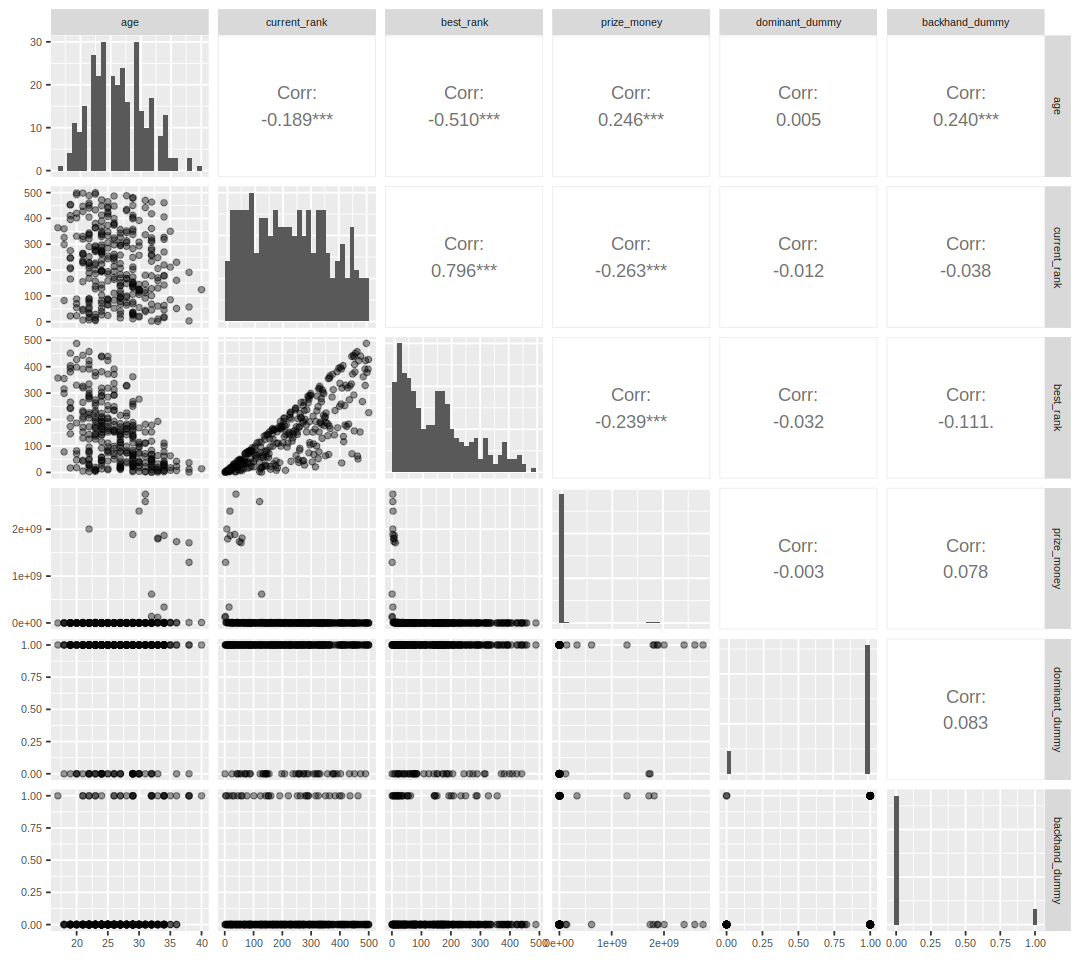

In [8]:
set.seed(1000) # DO NOT REMOVE

options(repr.plot.height = 8, repr.plot.width = 9)
 player_pairplot <- player_train |> 
                         
     ggpairs(
         lower = list(continuous = wrap('points', alpha = 0.4)),
         diag = list(continuous = "barDiag")
     ) +
     theme(text = element_text(size = 8))

player_pairplot
#Figure 0

From Figure 0, we could explore the relationship between the different variables. 
`age` ：
positive correlation (0.246) with `prize_money`
negative correlation (-0.189) with `current_rank`
negative correlation (-0.510) with `best_rank`
positive correlation (-0.240) with `backhand_dummy`
no significant correlation with `dominant_dummy`;

`current_rank`:
negative correlation (-0.263) with `prize_money`
positive correlation (-0.796) with `best_rank`
no significant correlation with `backhand_dummy`
no significant correlation with `dominant_dummy`;

`best_rank`:
negative correlation (-0.239) with `prize_money`
no significant correlation with `backhand_dummy`
no significant correlation with `dominant_dummy`;

## Prize Money vs Variables Comparisons:
In the next step, we will analyze each variable in relation to Prize money and how they correlate.

First, we will compare Prize Money and Current Rank:

In [ ]:
install.packages("parsnip")
library(parsnip)

In [ ]:
install.packages("hardhat")
library(recipes)

In [ ]:
# Run to see plot comparing prize money and current rank
options(repr.plot.width = 10, repr.plot.height = 5) 
small_plot_current_1 <- ggplot(player_train, aes(x = current_rank, y = prize_money)) +
  geom_point(alpha = 0.5) +
  xlab("Current Rank") +
  xlim(0, 500) +
  ylim(0, 2500000) +
  ylab("Prize Money (USD)") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Current Rank (Figure 1)")
small_plot_current_1

#Figure 1

We can see the relation of Prize money and Current Rank based on Figure 1. In Figure 1, we observed that money and ranks have negative relationship: in most cases, the higher the rank, the more money, but as the players go lower in rank, they will receive less money. 

Next we will compare the relationship between Best Rank and Prize money:

In [ ]:
# Run to see plot comparing prize money and best rank 

options(repr.plot.width = 10, repr.plot.height = 5) 
small_plot_best <- ggplot(player_train, aes(x = best_rank, y = prize_money)) +
  geom_point(alpha = 0.5) +
  xlab("Best Rank") +
  xlim(0, 500) +
  ylim(0, 2500000) +
  ylab("Prize Money (USD)") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Best Rank (Figure 2)")

small_plot_best

#Figure 2

Based on Figure 2, Prize Money vs. Best Rank, we can see a more precise negative relationship with both variables. The negative relationship is similar to the relationship in Figure 1: the higher the rank, the more money the player will receive, and as the ranks get lower, the less money a player will receive.

Based on Figure 1 and Figure 2, we observed that ranking will affect the amount of prize money the tennis player will receive.

Knowing that the rankings affect prize money, we want to see if the age of a player will relate to how much money they can receive. Below, we will create scatterplot to see the relationship between player's age in relation to prize money.

In [ ]:
# Run to see plot comparing prize money and age

options(repr.plot.width = 10, repr.plot.height = 5) 
small_plot_age <- ggplot(player_train, aes(x = age, y = prize_money)) +
  geom_point(alpha = 0.5) +
  xlab("Age") +
  xlim(12, 50) +
  ylim(0, 2500000) +
  ylab("Prize Money (USD)") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Age (Figure 3)")


small_plot_age

#Figure 3

With Figure 3, there is a slight positive relationship with age and prize money; Newer tennis athletes wouldn't receive much because they are new to the top-league competitions and wouldn't be playing in bigger competitions yet, while older players would receive more money because they are more experienced and with being more experienced, they are able to compete in the bigger tennis leagues to earn more money.

## Prize Money in Relation to Dominant and Backhand Variables:
We want to see how a player's prize money will be affected depending on what hand they use. Would right-handed players make more, less or the same amount as left-handed players? In order to compare this, we will analyze it using a boxplot for both their plays (when hand they usually play with) and their backhand (which hand they usually play when using backhand).
First, we want... (ADD MORE)

In [ ]:
dominant_dummy_1 <- player_train |>
 select(dominant_dummy, prize_money)|>
  filter (dominant_dummy==1)

head(dominant_dummy_1)

dominant_dummy_0 <- player_train |>
 select(dominant_dummy,  prize_money)|>
  filter (dominant_dummy==0)
head(dominant_dummy_0)

dominant_dummy_1_test <- player_test |>
 select(dominant_dummy, prize_money)|>
  filter (dominant_dummy==1)

head(dominant_dummy_1_test)

dominant_dummy_0_test <- player_test |>
 select(dominant_dummy,  prize_money)|>
  filter (dominant_dummy==0)
head(dominant_dummy_0_test)

In [ ]:
# Run to see plot comparing prize money and dominant hand

options(repr.plot.width = 7, repr.plot.height = 5) 
small_plot_hand_1 <- ggplot(dominant_dummy_1, aes(x = dominant_dummy, y = prize_money)) +
  geom_boxplot(alpha=0.4) +
  xlab("Dominant Hand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Left-handed", "Right-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant Hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Dominant Hand (right-handed)")


options(repr.plot.width = 7, repr.plot.height = 5) 
small_plot_hand_0 <- ggplot(dominant_dummy_0, aes(x = dominant_dummy, y = prize_money)) +
  geom_boxplot(alpha=0.4) +
  xlab("Dominant Hand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Left-handed", "Right-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant Hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Dominant Hand (left-handed)")


options(repr.plot.width = 12, repr.plot.height = 5) 
small_plot_hand <- plot_grid(
small_plot_hand_1,
  small_plot_hand_0,
     nrow = 1
 )

small_plot_hand
#Figure 4

As shown in Figure 4, Quartile 1 (lower quartile) of the prizes are roughly the same in both groups ($0 - $125,000). The median (middle quartile / Quartile 2) is very close between right-handed players and left-handed players, with half of the prizes greater than or equal to approximately $370,000 and half are less. The boxplot of right-handed player is comparatively short. This suggests that there is a greater range of variation in overall prize money for left-handed players compared to prize money for right-handed players. In fact, Quartile 3 of prizes for left-handed players ranges from about $370,000 to $900,000, while Quartile 3 of prizes for right-handed players ranges from about $370,000 to $600,000. Quartile 4 of the prizes for left-handed players ranged from about $900,000 to $2,000,000, while Quartile 4 of the prizes for right-handed players ranged from about $960,000 to $1,500,000. At the same time, there are more outliers (observations that are numerically very different from the rest of the data) in the right-handed group.

In [ ]:
backhand_dummy_1 <- player_train |>
 select(backhand_dummy, prize_money)|>
  filter(backhand_dummy==1)
head(backhand_dummy_1)

backhand_dummy_0 <- player_train |>
 select(backhand_dummy,  prize_money)|>
  filter(backhand_dummy==0)
head(backhand_dummy_0)


backhand_dummy_1_test <- player_test |>
 select(backhand_dummy, prize_money)|>
  filter(backhand_dummy==1)
head(backhand_dummy_1_test)

backhand_dummy_0_test <- player_test |>
 select(backhand_dummy,  prize_money)|>
  filter(backhand_dummy==0)
head(backhand_dummy_0_test)

The boxplot shows that left-handed players have very similar median (middle quartile) of prize money (about $\$260000 - $\$280000) compare with right-handed players. The distribution of the variance in prizes is larger for left-handed players than for right-handed players. The top 25% of left-handed player have relatively higher prize money, even though right-handed group tends to have more possibile outliers. A research paper states that over a 32-year period, left-handed male and female professional tennis singles players were significantly over-represented among successful athletes, which means that left-handed people are likely to be more talented in tennis than right-handed people (Holtzen, 2000).The results we reached are consistent with the conclusions in this paper. 

In [ ]:
# Run to see plot comparing prize money and backhand use

options(repr.plot.width = 7, repr.plot.height = 5) 
small_plot_backhand_1 <- ggplot(backhand_dummy_1, aes(x = backhand_dummy, y = prize_money)) +
  geom_boxplot(alpha=0.4) +
  xlab("Backhand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Two-handed","One-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Backhand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Backhand (one-handed)")

small_plot_backhand_0 <- ggplot(backhand_dummy_0, aes(x = backhand_dummy, y = prize_money)) +
  geom_boxplot(alpha=0.4) +
  xlab("Backhand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Two-handed","One-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Backhand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Backhand (two-handed)")

options(repr.plot.width = 12, repr.plot.height = 5) 
small_plot_backhand <- plot_grid(
small_plot_backhand_1,
small_plot_backhand_0,
     nrow = 1
 )

small_plot_backhand
#Figure 5

As shown in Figure 5, Quartile 1 (lower quartile) of the prizes are roughly the same in both groups ($0 - $125,000). The median prize (middle quartile / Quartile 2) of one-handed players (~ $375,000)is higher than two-handed players (~ $260,000). The boxplot of two-handed player is comparatively short. This suggests that there is a greater range of variation in overall prize money for one-handed players compared to prize money for two-handed players. In fact, Quartile 3 of prizes for one-handed players ranges from about $375,000 to $1,600,000, while Quartile 3 of prizes for two-handed players ranges from about $260,000 to $740,000. Quartile 4 of the prizes for one-handed players ranged from about $1,600,000 to $2,400,000, while Quartile 4 of the prizes for two-handed players ranged from about $740,000 to $1,500,000. At the same time, there are more outliers (observations that are numerically very different from the rest of the data) in the two-handed group.

## Model: Model Predictions (Current Rank)

In [ ]:
#run this cell to create linear regression model
lm_spec <- linear_reg() |>
           set_engine("lm") |>
           set_mode("regression")

In [ ]:
lm_recipe_current <- recipe(prize_money ~ current_rank, data = player_train)

lm_fit_current <- workflow() |>
  add_recipe(lm_recipe_current) |>
  add_model(lm_spec) |>
  fit(data = player_train)

options(repr.plot.width = 8, repr.plot.height = 7)

 current_preds <- lm_fit_current |>
   predict(player_train) |>
   bind_cols(player_train)

 lm_predictions_current <- current_preds |>
     ggplot(aes(x = current_rank, y = prize_money)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = current_rank, y = .pred), 
             color = "blue") +
         xlab("Current Rank") +
         ylab("Prize Money (Predicted)") +
         theme(text = element_text(size = 20))
lm_predictions_current

#Figure 6

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 7)


test_preds_current <- predict(lm_fit_current, player_test)
test_preds_final_current <- bind_cols(test_preds_current, player_test)

lm_predictions_current_test <- ggplot(data = player_test, aes(x = current_rank, y = prize_money)) +
  geom_point(alpha = 0.4) +
  geom_line(data = test_preds_final_current, aes(x = current_rank , y = .pred), color = "yellow", size = 1) +
      labs(x = "Current Rank", y = "Prize Money (Actual and Predicted)") +
  ggtitle("Linear Regression Model Predictions on Test Data") +
  theme(text = element_text(size = 20))


lm_predictions_current_test

#Figure 7

## Model: Model Predictions (Best Rank)

In [ ]:
lm_recipe_best <- recipe(prize_money ~ best_rank, data = player_train)

lm_fit_best <- workflow() |>
  add_recipe(lm_recipe_best) |>
  add_model(lm_spec) |>
  fit(data = player_train)

options(repr.plot.width = 8, repr.plot.height = 7)

best_preds <- lm_fit_best |>
   predict(player_train) |>
   bind_cols(player_train)

lm_predictions_best <- best_preds |>
     ggplot(aes(x = best_rank, y = prize_money)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = best_rank, y = .pred), 
             color = "blue") +
         xlab("Best Rank") +
         ylab("Prize Money (Predicted)") +
         theme(text = element_text(size = 20))

lm_predictions_best


In [ ]:
options(repr.plot.width = 8, repr.plot.height = 7)


test_preds_best <- predict(lm_fit_best, player_test)
test_preds_final_best <- bind_cols(test_preds_best, player_test)

lm_predictions_best_test <- ggplot(data = player_test, aes(x = best_rank, y = prize_money)) +
  geom_point(alpha = 0.4) +
  geom_line(data = test_preds_final_best, aes(x = best_rank , y = .pred), color = "yellow", size = 1) +
      labs(x = "Best Rank", y = "Prize Money (Actual and Predicted)") +
  ggtitle("Linear Regression Model Predictions on Test Data") +
  theme(text = element_text(size = 20))


lm_predictions_best_test

## Model: Model Predictions (Age)

In [ ]:
lm_recipe_age <- recipe(prize_money ~ age, data = player_train)

lm_fit_age <- workflow() |>
  add_recipe(lm_recipe_age) |>
  add_model(lm_spec) |>
  fit(data = player_train)

options(repr.plot.width = 8, repr.plot.height = 7)

age_preds <- lm_fit_age |>
   predict(player_train) |>
   bind_cols(player_train)

lm_predictions_age <- age_preds |>
     ggplot(aes(x = age, y = prize_money)) +
         geom_point(alpha = 0.4) +
         geom_line(
             mapping = aes(x = age, y = .pred), 
             color = "blue") +
         xlab("Age") +
         ylab("Prize Money (Predicted)") +
         theme(text = element_text(size = 20))

lm_predictions_age

In [ ]:
options(repr.plot.width = 8, repr.plot.height = 7)


test_preds_age <- predict(lm_fit_age, player_test)
test_preds_final_age <- bind_cols(test_preds_age, player_test)

lm_predictions_age_test <- ggplot(data = player_test, aes(x = age, y = prize_money)) +
  geom_point(alpha = 0.4) +
  geom_line(data = test_preds_final_age, aes(x = age , y = .pred), color = "yellow", size = 1) +
      labs(x = "Age", y = "Prize Money (Actual and Predicted)") +
  ggtitle("Linear Regression Model Predictions on Test Data") +
  theme(text = element_text(size = 20))


lm_predictions_age_test

## Model: Model Predictions (Dominant Hand)

In [ ]:
#Right-handed
lm_recipe_dominant_1 <- recipe(prize_money ~ dominant_dummy, data = dominant_dummy_1)

lm_fit_dominant_1 <- workflow() |>
  add_recipe(lm_recipe_dominant_1) |>
  add_model(lm_spec) |>
  fit(data = dominant_dummy_1)

dominant_1_preds <- lm_fit_dominant_1 |>
   predict(dominant_dummy_1) |>
   bind_cols(dominant_dummy_1)

lm_predictions_dominant_1 <- dominant_1_preds |>
     ggplot(aes(x = dominant_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Dominant hand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Left-handed","Right-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Dominant Hand (right-handed) on Training Data")

#Left-handed
lm_recipe_dominant_0 <- recipe(prize_money ~ dominant_dummy, data = dominant_dummy_0)

lm_fit_dominant_0 <- workflow() |>
  add_recipe(lm_recipe_dominant_0) |>
  add_model(lm_spec) |>
  fit(data = dominant_dummy_0)

dominant_0_preds <- lm_fit_dominant_0 |>
   predict(dominant_dummy_0) |>
   bind_cols(dominant_dummy_0)

lm_predictions_dominant_0 <- dominant_0_preds |>
     ggplot(aes(x = dominant_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Dominant hand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Left-handed","Right-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Dominant Hand (left-handed) on Training Data")




options(repr.plot.width = 12, repr.plot.height = 5) 



lm_predictions_dominant <- plot_grid(
lm_predictions_dominant_1,
lm_predictions_dominant_0,
     nrow = 1
 )
lm_predictions_dominant

In [ ]:
#Right-handed
lm_recipe_dominant_1_test <- recipe(prize_money ~ dominant_dummy, data = dominant_dummy_1_test)

lm_fit_dominant_1_test <- workflow() |>
  add_recipe(lm_recipe_dominant_1_test) |>
  add_model(lm_spec) |>
  fit(data = dominant_dummy_1_test)

dominant_1_preds_test <- lm_fit_dominant_1_test |>
   predict(dominant_dummy_1_test) |>
   bind_cols(dominant_dummy_1_test)

lm_predictions_dominant_1_test <- dominant_1_preds_test |>
     ggplot(aes(x = dominant_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Dominant hand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Left-handed","Right-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Dominant Hand (right-handed) on Test Data")

#Left-handed
lm_recipe_dominant_0_test <- recipe(prize_money ~ dominant_dummy, data = dominant_dummy_0_test)

lm_fit_dominant_0_test <- workflow() |>
  add_recipe(lm_recipe_dominant_0_test) |>
  add_model(lm_spec) |>
  fit(data = dominant_dummy_0_test)

dominant_0_preds_test <- lm_fit_dominant_0_test |>
   predict(dominant_dummy_0_test) |>
   bind_cols(dominant_dummy_0_test)

lm_predictions_dominant_0_test <- dominant_0_preds_test |>
     ggplot(aes(x = dominant_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Dominant hand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Left-handed","Right-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Dominant hand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Dominant Hand (left-handed) on Test Data")




options(repr.plot.width = 12, repr.plot.height = 5) 



lm_predictions_dominant_test <- plot_grid(
lm_predictions_dominant_1_test,
lm_predictions_dominant_0_test,
     nrow = 1
 )
lm_predictions_dominant_test

## Model: Model Predictions (BackHand)

In [ ]:
#One-handed
lm_recipe_backhand_1 <- recipe(prize_money ~ backhand_dummy, data = backhand_dummy_1)

lm_fit_backhand_1 <- workflow() |>
  add_recipe(lm_recipe_backhand_1) |>
  add_model(lm_spec) |>
  fit(data = backhand_dummy_1)

backhand_1_preds <- lm_fit_backhand_1 |>
   predict(backhand_dummy_1) |>
   bind_cols(backhand_dummy_1)

lm_predictions_backhand_1 <- backhand_1_preds |>
     ggplot(aes(x = backhand_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Backhand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Two-handed","One-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Backhand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Backhand (one-handed) on Training Data")

#Two-handed
lm_recipe_backhand_0 <- recipe(prize_money ~ backhand_dummy, data = backhand_dummy_0)

lm_fit_backhand_0 <- workflow() |>
  add_recipe(lm_recipe_backhand_0) |>
  add_model(lm_spec) |>
  fit(data = backhand_dummy_0)

backhand_0_preds <- lm_fit_backhand_0 |>
   predict(backhand_dummy_0) |>
   bind_cols(backhand_dummy_0)

lm_predictions_backhand_0 <- backhand_0_preds |>
     ggplot(aes(x = backhand_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Backhand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Two-handed","One-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Backhand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Backhand (two-handed) on Training Data")




options(repr.plot.width = 12, repr.plot.height = 5) 



lm_predictions_backhand <- plot_grid(
lm_predictions_backhand_1,
lm_predictions_backhand_0,
     nrow = 1
 )
lm_predictions_backhand

In [ ]:
#One-handed
lm_recipe_backhand_1_test <- recipe(prize_money ~ backhand_dummy, data = backhand_dummy_1_test)

lm_fit_backhand_1_test <- workflow() |>
  add_recipe(lm_recipe_backhand_1_test) |>
  add_model(lm_spec) |>
  fit(data = backhand_dummy_1_test)

backhand_1_preds_test <- lm_fit_backhand_1_test |>
   predict(backhand_dummy_1_test) |>
   bind_cols(backhand_dummy_1_test)

lm_predictions_backhand_1_test <- backhand_1_preds_test |>
     ggplot(aes(x = backhand_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Backhand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Two-handed","One-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Backhand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Backhand (one-handed) on Test Data")

#Two-handed
lm_recipe_backhand_0_test <- recipe(prize_money ~ backhand_dummy, data = backhand_dummy_0_test)

lm_fit_backhand_0_test <- workflow() |>
  add_recipe(lm_recipe_backhand_0_test) |>
  add_model(lm_spec) |>
  fit(data = backhand_dummy_0_test)

backhand_0_preds_test <- lm_fit_backhand_0_test |>
   predict(backhand_dummy_0_test) |>
   bind_cols(backhand_dummy_0_test)

lm_predictions_backhand_0_test <- backhand_0_preds_test |>
     ggplot(aes(x = backhand_dummy, y = prize_money)) +
 geom_boxplot(alpha=0.4) +
  xlab("Backhand") +
  xlim(0,1) +
  ylim(0, 2500000) +
  scale_x_continuous(breaks = c(0, 1), labels = c("Two-handed","One-handed")) +
  ylab("Prize Money (USD)") +
  labs(color = "Backhand") +
  theme(text = element_text(size = 12)) +
  ggtitle("Prize Money (USD) VS Backhand (two-handed) on Test Data")




options(repr.plot.width = 12, repr.plot.height = 5) 



lm_predictions_backhand_test <- plot_grid(
lm_predictions_backhand_1_test,
lm_predictions_backhand_0_test,
     nrow = 1
 )
lm_predictions_backhand_test

## Model: Linear Regression (Multivariable)
After analyzing the different variables in comparison to prize money, we want to calculate for the RMSPE of the data. We want to calculate the RMSPE of both the training data set and testing training set and compare them. This purpose of the RMSPE in these cases is to test the accuracy of our model. Thus, we first want to create the training set model we will use to predict our accuracy.

In [ ]:
lm_spec <- linear_reg() |>
  set_engine("lm") |>
  set_mode("regression")

lm_recipe_train <- recipe(prize_money ~ ., data = player_train) |>
  update_role(prize_money, new_role = "outcome")


lm_fit_train <- workflow() |>
  add_recipe(lm_recipe_train) |>
  add_model(lm_spec)|>
  fit(data=player_train)

player_preds <- lm_fit_train |>
   predict(player_train) |>
   bind_cols(player_train)

lm_rmspe_train <- lm_fit_train |>
         predict(player_train) |>
         bind_cols(player_train) |>
         metrics(truth = prize_money, estimate = .pred)|>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()
lm_rmspe_train 

After creating the model for our training model, we calculated for the model's RMSPE, which ended up being 357155722.800104 and also turns out to be the slope for our multi-variable linear regression (which we cannot calculate). With this information, we don't know how accurate our training model is compared to our training set, which leads to our next step: Calculating for the RMSPE of the testing set.

In [ ]:
lm_recipe_test <- recipe(prize_money ~ ., data = player_test) |>
  update_role(prize_money, new_role = "outcome")


lm_fit_test <- workflow() |>
  add_recipe(lm_recipe_test) |>
  add_model(lm_spec)|>
  fit(data=player_test)

player_preds <- lm_fit_test |>
   predict(player_test) |>
   bind_cols(player_test)

lm_rmspe_test <- lm_fit_test |>
         predict(player_test) |>
         bind_cols(player_test) |>
         metrics(truth = prize_money, estimate = .pred)|>
         filter(.metric == "rmse") |>
         select(.estimate) |>
         pull()
lm_rmspe_test

The RMSPE we found for our testing data is 372464532.64195. The purpose of the testing RMSPE is to help us assess the general ability of the model. Knowing that our m
We get slopes/intercept from linear regression. We extract those slope values from our model object as shown below:

In [ ]:
mcoeffs <- lm_fit_test |>
             extract_fit_parsnip() |>
             tidy()

mcoeffs

#Table 2

And then use those slopes to write a mathematical equation to describe the prediction plane:

prize money = `β0` + `β1`⋅(age) + `β2`⋅(current rank) + `β3`⋅(best rank) + `β4`⋅(dominant hand) + `β5`⋅(backhand)

`β0` is the vertical intercept of the hyperplane (the prize money when all variables are 0)

`β1` is the slope for the first predictor (the rate of change in prize money as players age, holding all other control variables constant)

`β2` is the slope for the second predictor (the rate of change in prize money as a player's current ranking falls, holding all other control variables constant)

`β3` is the slope for the third predictor (the rate of change in prize money as a player's best ranking falls, holding all other control variables constant)

`β4` is the slope for the fourth predictor (the rate of change in prize money when a player uses his right hand, holding all other control variables constant)

`β5` is the slope for the fifth predictor (the rate of change in prize money when a player hits the ball with a one-handed backhand, holding all other control variables constant)

Finally, we can fill in the values for `β0`, `β1`, `β2`, `β3`, `β4`, `β5` from the model output above to create the equation of the plane of best fit to the data:

prize money = -350431610.3 + 15935143.5⋅(age) − 793521.2⋅(current rank) + 210345.6⋅(best rank) + 151159217.6⋅(dominant hand) + 104711771.3⋅(backhand)

## Discussion:
Our findings indicate that the best ranking points has the postive impact on increasing prize money (since smaller ranking points represent higher rankings, the positive coefficient means that the higher ranking points, the higher the prize money, and the lower ranking points, the lower the prize money). For each lower ranking, the prize money increases by $210,345.6. The current ranking points has the negative impact on increasing prize money (since smaller ranking points represent higher rankings, the negative coefficient means that the lower ranking points, the higher the prize money, and the higher ranking points, the lower the prize money). For each higher ranking, the prize money increases by $793,521.2.

We expected that our main independet variable current ranking points and best ranking points would have negative correlation with prize money (since smaller ranking points represent higher rankings, the negative coefficient means that the smaller ranking points, the higher the prize money) . However, the results of best ranking points the results of the best ranking points were not what we expected. We guess this is due to the fact that we are using a linear regression model and the dataset is not fitted enough. From Figure 2 we can see that the relationship between current rank and prize money is non-linear correlation, so in the future maybe we should use a more accurate regression model. A paper that examines the relationship between tennis rankings and prize money states that in 2017, the top 100 tennis players in the rankings received about 90 % of the total prize money on the tour that year, and inequality is also evident in the top 100, with the top 20 players earning more than 55  of all prize money, while the bottom half of the top 100 received less than one-fifth of the prize money of the top 100 (JEANGOUT, 2017).

We can also conclude that age has the postive impact on increasing prize money. For each additional year of age, the prize money increases by $15,935,143.5.  For dominant hands, our results show that right-handed players will have an additional $151,159,217.6 in prize money. For backhand use, our results show that one-handed players will have an additional $415,900,163.0 in prize money.




- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?

## References
- At least 2 citations of literature relevant to the project (format is your choice, just be consistent across the references).
- Make sure to cite the source of your data as well.

1. Holtzen, D. W. (2000). Handedness and Professional Tennis. International Journal of Neuroscience, 105(1-4), 101–119. https://doi.org/10.3109/00207450009003270

2. JEANGOUT, C., & Vannetelbosch, V. " Analysis of the Evolution of Inequalities in Prize Money due to Ranking in Professional Tennis.